# Importation of packages

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import sklearn

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist

from skimage import measure
%pylab inline
import itertools
import statistics
import scipy

# for colab >> if not on colab, change the function cv2_imshow with the true function of cv2
from google.colab.patches import cv2_imshow

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
chemin = "drive/MyDrive/BME/Artificial_Intelligence_in_Data_Science/class_5/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

Importation of the MNIST Database

In [ ]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

In [ ]:
def preprocessing(X):
  X = X.astype("float32") / 255
  X = X.reshape(X.shape[0],28,28,1)
  return X

In [ ]:
num_classes = 10

X_train = preprocessing(x_train)
X_test = preprocessing(x_test)

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

# Model creation : CNN, fitting and evaluation

I used Convutional layers to have better accuracy.

In [ ]:
model = Sequential()
model.add(Conv2D(32, activation='relu', input_shape = (28, 28, 1), padding='same', kernel_size=(3,3)))
model.add(Conv2D(64, activation='relu', padding='same', kernel_size=(2,2)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu', input_shape = (256, )))
model.add(Dropout(0.2))
model.add(Dense(10,activation= "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        8256      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [ ]:
# Training the model
fitted_model = model.fit(X_train, y_train, epochs=15, batch_size=128, verbose=1, validation_split = 0.1)

Epoch 1/15
422/422 [==============================] - 10s 19ms/step - loss: 0.2067 - accuracy: 0.9369 - val_loss: 0.0520 - val_accuracy: 0.9858
Epoch 2/15
422/422 [==============================] - 8s 18ms/step - loss: 0.0596 - accuracy: 0.9815 - val_loss: 0.0427 - val_accuracy: 0.9875
Epoch 3/15
422/422 [==============================] - 7s 18ms/step - loss: 0.0399 - accuracy: 0.9873 - val_loss: 0.0361 - val_accuracy: 0.9902
Epoch 4/15
422/422 [==============================] - 7s 18ms/step - loss: 0.0299 - accuracy: 0.9909 - val_loss: 0.0403 - val_accuracy: 0.9888
Epoch 5/15
422/422 [==============================] - 7s 17ms/step - loss: 0.0220 - accuracy: 0.9928 - val_loss: 0.0444 - val_accuracy: 0.9887
Epoch 6/15
422/422 [==============================] - 7s 18ms/step - loss: 0.0181 - accuracy: 0.9937 - val_loss: 0.0357 - val_accuracy: 0.9913
Epoch 7/15
422/422 [==============================] - 7s 18ms/step - loss: 0.0165 - accuracy: 0.9945 - val_loss: 0.0350 - val_accuracy: 0.990

In [ ]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0387 - accuracy: 0.9910


[0.03874022886157036, 0.9909999966621399]

# Detection and classification of numbers

The use of Kmeans didn't work so this is another way to segment the image. We put it in gray then we verify that the number is in white. Then, we scale it to make the number closed to 255 and black and black-grey will be put to zeros.
We also create the connected components with an image that has pixels who are either 0 or 255. We return our res (segmented image that has value betwwen 0 and 255), our other image that has two value 0 or 255 for every pixel and then the patches.

In [ ]:
def segment_image(img):
  res = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  if np.mean(res)>255/2:
    res= 255 - res

  res-=np.min(res)
  res = np.array(res / np.max(res) * 255,int)
  res = np.array((res > np.mean(res) + 1.5*np.std(res)), int)  * (res) 

  res_full = np.array((res > np.mean(res) + 1.5*np.std(res)), int) 
  regions = measure.label(res_full,connectivity=1,background=-10)
  patches = measure.regionprops(regions)

  return res,res_full, patches

Functions that are used to filter the patches

In [ ]:
def bool_area_superior(patch,image, threshold_min):
  area_of_image = image.shape[0] * image.shape[1]
  area_of_patch = patch.area
  return area_of_patch > threshold_min * area_of_image

In [ ]:
def bool_compare_to_image(patch, image, threshold):
  area_of_image = image.shape[0] * image.shape[1]
  area_of_patch = patch.area
  return area_of_patch < threshold * area_of_image

In [ ]:
def bool_aspect_ratio(patch, min_threshold, max_threshold):
  delta_x = np.abs(patch.bbox[2]-patch.bbox[0])
  delta_y = np.abs(patch.bbox[3]-patch.bbox[1])

  ratio = delta_x/delta_y

  return ratio > min_threshold and ratio < max_threshold

In [ ]:
def bool_divergence(patch,patches, threshold):
  mean_height = 0
  for patch_i in patches :
    mean_height+=np.abs(patch_i.bbox[0]-patch_i.bbox[2])
  mean_height/=len(patches)

  height = np.abs(patch.bbox[0]-patch.bbox[2])
  return (mean_height-height)/mean_height < threshold

Functions used to create the little images from the regions where our numbers are (possibly) and we resize it in the good format.

In [ ]:
def resizing_partitions(img, patches, targeted_size):
  ens_img_resized = np.zeros((len(patches), targeted_size[0], targeted_size[1]))

  i = 0
  for patch in patches :

    height = np.abs(patch.bbox[2]-patch.bbox[0])
    width = np.abs(patch.bbox[3]-patch.bbox[1])

    anchor_y = patch.bbox[0]
    anchor_x = patch.bbox[1]

    partition_img = img[anchor_y:anchor_y+height,anchor_x:anchor_x+width]

    partition_img = partition_img.astype('float32')
    partition_img_resized = cv2.resize(partition_img, targeted_size)

    ens_img_resized[i] = partition_img_resized
    i+=1

  return ens_img_resized

Another function identical to the previous one but will make bigger the rectangles surrounding and directly transform the rectangle to a square without stretching the image. Like that, the little images will look like the MNIST image.

In [ ]:
def make_rectangle_bigger(img,anchor_x,anchor_y,width,height):
  aggranding_scale = 4/3

  new_height = int(height * aggranding_scale)
  delta_height = new_height - height

  anchor_y -= delta_height/2
  anchor_y = int(np.maximum(anchor_y,0))

  new_width = height
  delta_width = new_width - width

  anchor_x -= delta_width/2
  anchor_x = int(np.maximum(anchor_x,0))

  return anchor_x,anchor_y,new_width,new_height

In [ ]:
def resizing_partitions_with_extra_space(img, patches, targeted_size):
  ens_img_resized = np.zeros((len(patches), targeted_size[0], targeted_size[1]))

  i = 0
  for patch in patches :

    height = np.abs(patch.bbox[2]-patch.bbox[0])
    width = np.abs(patch.bbox[3]-patch.bbox[1])

    anchor_y = patch.bbox[0]
    anchor_x = patch.bbox[1]


    anchor_x,anchor_y,width,height = make_rectangle_bigger(img,anchor_x,anchor_y,width,height)


    partition_img = img[anchor_y:anchor_y+height,anchor_x:anchor_x+width]

    partition_img = partition_img.astype('float32')
    partition_img_resized = cv2.resize(partition_img, targeted_size)

    ens_img_resized[i] = partition_img_resized
    i+=1

  return ens_img_resized

These two function are used to filter the predictions and put the results in a convenient way. We filter on the confidence but also thanks to the second function on how the boxes intersect each other. This problem is a bit present on the images especially the first one. If two boxes are very close or one is another one, it will keep just one box.

In [ ]:
def filter_results(results, res_patches,CONF_THRESHOLD):
  boxes, confidences, class_ids = [], [], []

  for i in range(results.shape[0]):
    width = np.abs(res_patches[i].bbox[2]-res_patches[i].bbox[0])
    height = np.abs(res_patches[i].bbox[3]-res_patches[i].bbox[1])

    anchor_x = res_patches[i].bbox[0]
    anchor_y = res_patches[i].bbox[1]

    box = [int(anchor_y),int(anchor_x),int(height),int(width)]
    
    class_id = np.argmax(results[i])
    confidence = results[i][class_id]
    

    if confidence > CONF_THRESHOLD :
      boxes.append(box)
      confidences.append(float(confidence))
      class_ids.append(class_id)

  return boxes, confidences, class_ids

In [ ]:
def eliminate_dupplications(boxes, confidences,SCORE_THRESHOLD,IOU_THRESHOLD):
  idxs = cv2.dnn.NMSBoxes(boxes, confidences, SCORE_THRESHOLD, IOU_THRESHOLD) # for more explanation, see documentation of the function
  return idxs

Functions to display images

This function is used to display the boxes of the connected regions.

In [ ]:
def plot_boxes(patches, img): 
  fig, (ax1) = plt.subplots(1,figsize=(20,20))
  plt.xticks([]),plt.yticks([])
  ax1.imshow(img);
  for patch in patches :

    width = np.abs(patch.bbox[2]-patch.bbox[0])
    height = np.abs(patch.bbox[3]-patch.bbox[1])

    anchor_x = patch.bbox[0]
    anchor_y = patch.bbox[1]
    
    rectBorder = matplotlib.patches.Rectangle(\
                (anchor_y, anchor_x),  height, width, edgecolor="red", linewidth=2, fill=False)
    ax1.add_patch(rectBorder)

  plt.show()

This function is used to put rectangles around the numbers with their predicted value.

In [ ]:
def create_image(idxs, boxes, class_ids, confidences, colors, img):
  font_scale = 0.6
  thickness = 1 

  res_boxes = []
  res_confidences = []
  res_class_ids = []

  # il existe au moins une prediction
  if len(idxs) > 0:
      # on regarde tous les indexes crees
      for i in idxs.flatten():
        # on prend les coords des boites
        x, y = boxes[i][0], boxes[i][1]
        w, h = boxes[i][2], boxes[i][3]
        # on cree le rectangle et on donne le nom de la classe a la boites
        color = [int(c) for c in colors[class_ids[i]]]
        cv2.rectangle(img, (x, y), (x + w, y + h), color=color, thickness=thickness)

        # calcul de la police etc... juste esthetique
        box_coords = [(x,y),(x+w,y+h)]

        overlay = img.copy()
        cv2.rectangle(overlay, box_coords[0], box_coords[1], color=color, thickness=thickness)

        res_boxes.append(boxes[i])
        res_confidences.append(confidences[i])
        res_class_ids.append(class_ids[i])

  
  # il existe au moins une prediction
  if len(idxs) > 0:
    image=None
    # transparence de la boite
    image = cv2.addWeighted(overlay, 0.6, img, 0.4, 0)

    # on regarde tous les indexes crees
    for i in idxs.flatten():
      # on prend les coords des boites
      x, y = boxes[i][0], boxes[i][1]
      cv2.putText(img=image, text=str(class_ids[i]), org=(x, y+14), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=font_scale, color=(0, 0, 0),thickness=thickness)


  return image, res_boxes, res_class_ids, res_confidences


Parameters

In [ ]:
# filter the patches
MIN_THRESHOLD = 0.1
MAX_THRESHOLD = 12
THRESHOLD_RATIO_MIN_AREA = 0.0001
THRESHOLD_RATIO_MAX_AREA = 0.1
THRESHOLD_DIV = 0.05

# filter
CONFIDENCE_THRESHOLD = 0.7
SCORE_THRESHOLD = CONFIDENCE_THRESHOLD
IOU_THRESHOLD = 0.01

Reading of the image, creation of the patches and filtering of the patches

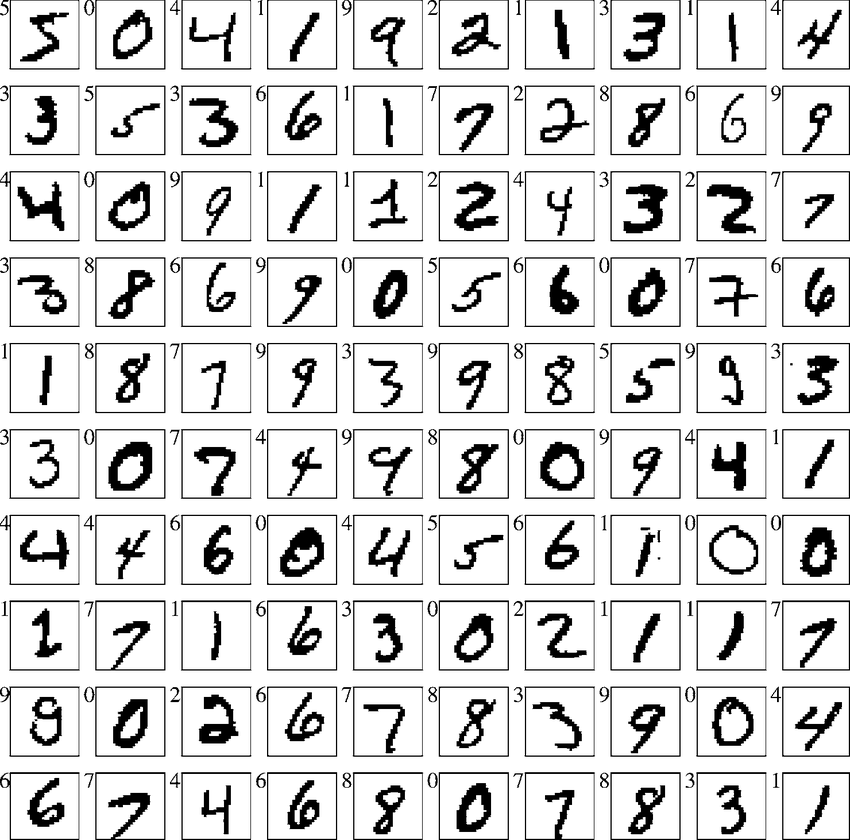

151

In [ ]:
img = cv2.imread(chemin+"numbers.png")
cv2_imshow(img)

# segmentation
img_seg, img_seg_full, patches = segment_image(img)

res_temp_patches = []
res_patches = []

# filtering of patches
for patch in patches :
  condition = bool_area_superior(patch, img, THRESHOLD_RATIO_MIN_AREA) and bool_compare_to_image(patch, img, THRESHOLD_RATIO_MAX_AREA) and bool_aspect_ratio(patch, MIN_THRESHOLD, MAX_THRESHOLD)
  if condition :
    res_temp_patches.append(patch)

for patch in res_temp_patches :
  condition = bool_divergence(patch, res_temp_patches, THRESHOLD_DIV)

  if condition :
    res_patches.append(patch)

len(res_patches)

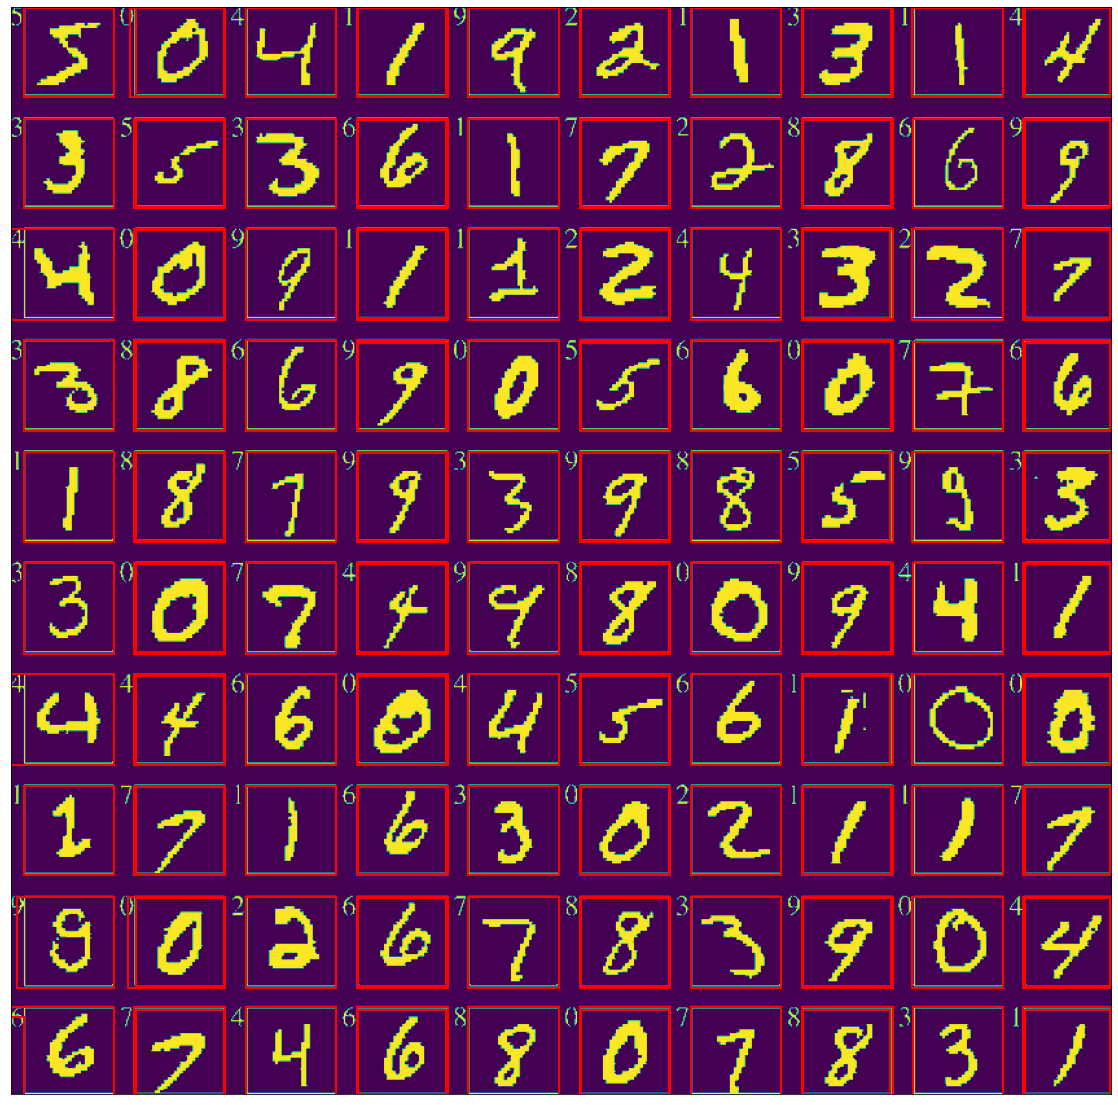

In [ ]:
plot_boxes(res_patches, img_seg)

We resize and create the little images to pass them through the NN with the same format (28,28,1) with values from 0 to 1. 1 when we are on the number.

In [ ]:
targeted_size = (x_train.shape[1],x_train.shape[2])

ens_img_sized = resizing_partitions(img_seg, res_patches, targeted_size)

X_partitions = preprocessing(ens_img_sized)
pred_partitions = model.predict(X_partitions)

for i in range(5):  
  cv2_imshow(ens_img_sized[i])

In [ ]:
X_partitions.shape

(151, 28, 28, 1)

We filter the results to keep the boxes with high confidence, that do not share to much space with another box.

Then we display the results.

Total patches :  151
After filtering on confidence:  150
After deleting dupplications or images in images :  99


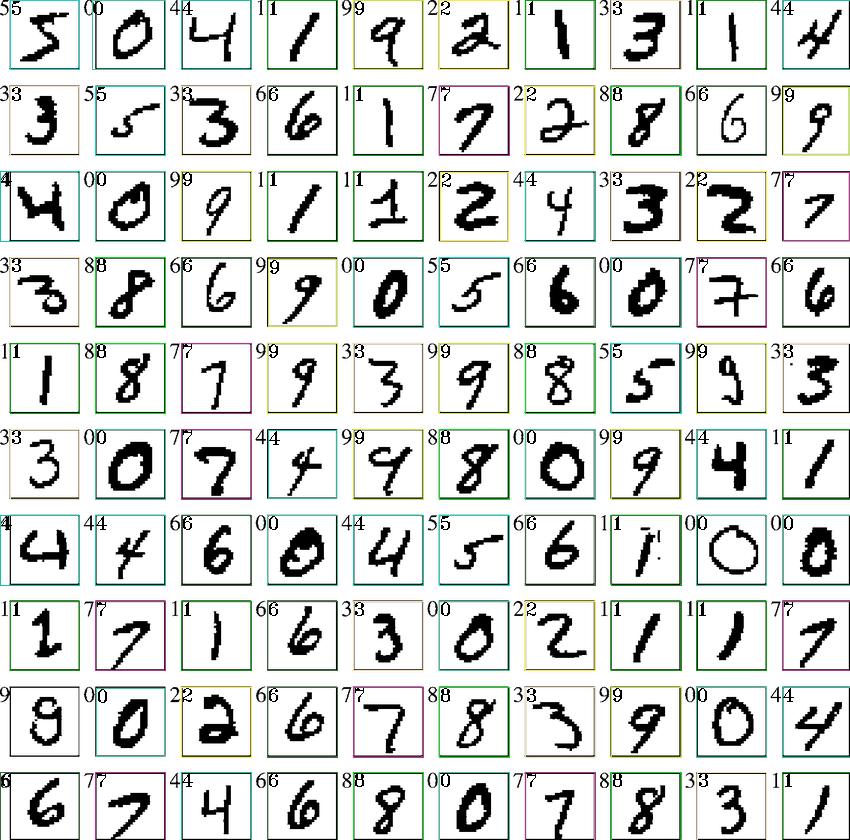

In [ ]:
print("Total patches : ", X_partitions.shape[0])
boxes, confidences, class_ids = filter_results(pred_partitions, res_patches, CONFIDENCE_THRESHOLD)
print("After filtering on confidence: ", len(boxes))
idxs = eliminate_dupplications(boxes, confidences,SCORE_THRESHOLD,IOU_THRESHOLD)
print("After deleting dupplications or images in images : ", len(idxs))

colors = np.random.randint(0, 255, size=(10, 3), dtype="uint8")
image, res_boxes, res_class_ids, res_confidences = create_image(idxs, boxes, class_ids, confidences, colors, img)
cv2_imshow(image)

On the MNIST images, we have almost 100% accuracy with this image (99%). The only number not identified is the nine at the botton left who looks like a 8. The NN doesn't know the answer so doesn't have a lot of confidence and the confidence threshold will erase this box. The hight accuracy is also due to the fact that numbers have squares surrounding them making it easier to predict with the right box.

# Detection on the other images

Parameters

In [ ]:
  MIN_THRESHOLD = 0.5
  MAX_THRESHOLD = 5

  THRESHOLD_RATIO_MIN_AREA = 0.001
  THRESHOLD_RATIO_MAX_AREA = 0.1
  THRESHOLD_DIV = 0.05

  CONFIDENCE_THRESHOLD = 0.3
  SCORE_THRESHOLD = CONFIDENCE_THRESHOLD
  IOU_THRESHOLD = 0.01

Accuracy :

1 : 5/11

2 : 5/8

3 : 1/6

4 : 0 > problem with segmentation

5 : 4/5

6 : 3/6

7 : 6/6 perfect score

8 : 6/6 perfect score

9 : 6/6 perfect score

Overall score : 60%


We see one the images that there can be problems with segmentation (especially for one) but also the creation of the patches sometimes doesn't work properly. It will then not identify the numbers. However, we see that it works in a lot of case. Then, the problem can be on the classification.

To have better results, we could change individually the parameters for each image and change the segmentation for images that doesn't get correctly segmented.



In [ ]:
for i in range(1,10):
  print("############## Image "+str(i)+" ###############")
  img = cv2.imread(chemin+str(i)+".png")
  cv2_imshow(img)

  # segmentatio of the image
  img_seg, img_seg_full, patches = segment_image(img)

  # filtering the patches
  res_temp_patches = []
  res_patches = []

  for patch in patches :
    condition = bool_area_superior(patch, img, THRESHOLD_RATIO_MIN_AREA) and bool_compare_to_image(patch, img, THRESHOLD_RATIO_MAX_AREA) and bool_aspect_ratio(patch, MIN_THRESHOLD, MAX_THRESHOLD)
    if condition :
      res_temp_patches.append(patch)

  for patch in res_temp_patches :
    condition = bool_divergence(patch, res_temp_patches, THRESHOLD_DIV)

    if condition :
      res_patches.append(patch)


  # display the boxes
  plot_boxes(res_patches, img_seg)

  # creation of the small images for prediction
  targeted_size = (x_train.shape[1],x_train.shape[2])
  ens_img_sized = resizing_partitions_with_extra_space(img_seg, res_patches, targeted_size)

  if len(ens_img_sized)>0:
    # same preprocessing as MNIST images
    X_partitions = preprocessing(ens_img_sized)
    # prediction
    pred_partitions = model.predict(X_partitions)

    # filtering the boxes/predctions
    print("Max confidence : ", np.max(pred_partitions))
    print("Total patches : ", X_partitions.shape[0])
    boxes, confidences, class_ids = filter_results(pred_partitions, res_patches, CONFIDENCE_THRESHOLD)
    print("After filtering on confidence: ", len(boxes))
    idxs = eliminate_dupplications(boxes, confidences,SCORE_THRESHOLD,IOU_THRESHOLD)
    print("After deleting dupplications or images in images : ", len(idxs))
    print("Numbers identified : ", set(class_ids))

    # creation of the image to display results
    colors = np.random.randint(0, 255, size=(10, 3), dtype="uint8")
    image, res_boxes, res_class_ids, res_confidences = create_image(idxs, boxes, class_ids, confidences, colors, img)

    cv2_imshow(image)

    # show the numbers detected in order
    data_of_numbers = pd.DataFrame({"x_0":np.array(res_boxes)[:,0],
                                    "y_0":np.array(res_boxes)[:,1],
                                    "x_1":np.array(res_boxes)[:,0] + np.array(res_boxes)[:,2],
                                    "y_1":np.array(res_boxes)[:,1] + np.array(res_boxes)[:,2],
                                    "number" : res_class_ids})
    
    print("Number in order (for x) :",list(data_of_numbers.sort_values("x_0")['number']))    
    
  else :
    print("No number identified")

Output hidden; open in https://colab.research.google.com to view.